# Homework 2
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [1]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

import numpy as np
import math
import matplotlib.pyplot as plt
import random

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [2]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [3]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

In [4]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400):
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg
    
    sigmaNoise = np.sqrt(skyBg)

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]

### Task 1
Generate a few (say, three) simulated image of a star using the simulatedImage function for different seed values, and visualize them using plotCutout. Run psfPhot and apPhot on the results of each image, and print the estimated flux.

The AP and PSF fluxes for image with seed  10  are  1001.0  and  1044  respectively
The AP and PSF fluxes for image with seed  3  are  921.0  and  1006  respectively
The AP and PSF fluxes for image with seed  25  are  964.0  and  1054  respectively


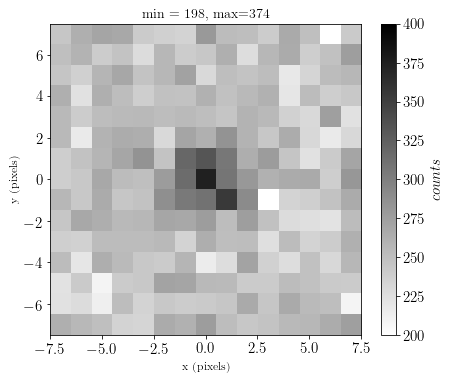

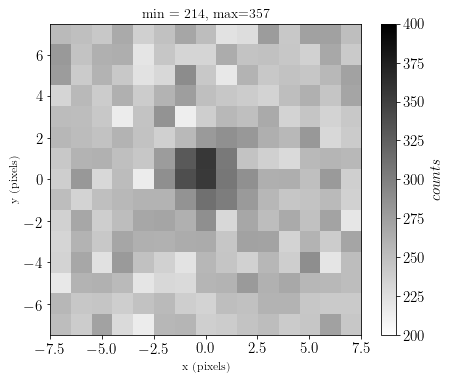

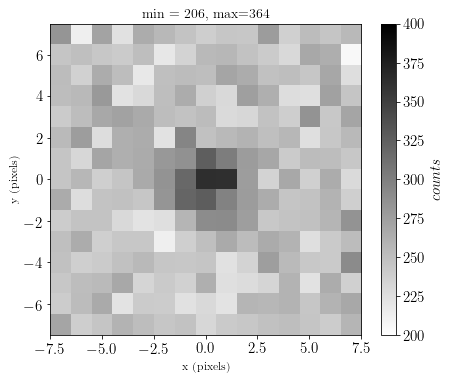

In [5]:
for i in [10,3,25]:      
    image=simulatedImage(i)               #Images for 3 random seeds
    plotCutout(image)                     #Display the simulated image
    ap=apPhot(image)                      #Calculate AP flux
    ps=psfPhot(image)                     #Calcualate PSF flux
    print("The AP and PSF fluxes for image with seed ", i, " are ", ap ," and ", ps, " respectively")

### Task 2

In [6]:
def centerPhot(image):
    """
    Approximates the flux of the star as the value in the central pixel of the image.
    Takes an array.
    Returns the value of the central pixel of the image's array after subtracting the background.
    """
    c_flux = image[7,7] - skyBg            #As the dimensions are 15x15, the central pixel has coordinates 8,8. But Python starts indexing from 0
    return c_flux

In [7]:
image= simulatedImage(10)           #Take a test image
print("Its's flux is : ",centerPhot(image))

Its's flux is :  124.0


Comment on the result!

**Comment:** As discussed in the class, the point-like object's image gets distorted due to aberrations caused by many effects. As a result the photons get spread out. To approximate the central pixel's value to be the light source's magnitude would be too rudimentary as it would not be the same over time. The atmospheric effects will change this value constantly. The photons are distributed over the pixels, which we model as the PSF. As a result, the estimator will be biased.

### Task 3 / 4

Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

In [8]:
def Photometry(img_num, corrected):
    
    """
    Produces "img_num" images using simulatedImage function and computes various fluxes.
    Plots the histogram for the distribution of the fluxes.
    Calculates Mean and St. Dev
    Does the same with the correction factor included if the "corrected" argument is put as True.
    
    Input: img_num --> positive integer
           corrected --> Boolean "True" or "False"
    """
    rs=random.sample(range(1,10000),int(img_num))

    aps=[]
    pss=[]
    cps=[]
    for i in range(len(rs)):
        image=simulatedImage(i)
        
        aps.append(apPhot(image))
        pss.append(psfPhot(image))
        cps.append(centerPhot(image))
        
    if corrected==True:
        aps=np.array(aps)*Atrue/np.average(aps)
        pss=np.array(pss)*Atrue/np.average(pss)
        cps=np.array(cps)*Atrue/np.average(cps)
        print("Values are corrected!!\n")
        
    
    print("Order of values: Aperture, PSF, Central")
    print("Means are: ", np.average(aps), np.average(pss), np.average(cps))
    print("Standard Deviations are: %.3f, %.3f, %.3f" % (np.std(aps), np.std(pss), np.std(cps)) )


    fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True )
    fig.subplots_adjust(wspace=0.01)
    fig.suptitle("Histograms of fluxes", fontsize=30)
    fig.text(0.5, 0.01, 'Flux', ha='center', fontsize=20)
    
    
    ax[0].hist(aps, alpha = 0.5, color = 'r', label="AP Flux")
    ax[0].set_ylabel("Count")
    
    
    ax[1].hist(pss, alpha = 0.5, color = 'g', label= "PSF Flux")
    
    
    ax[2].hist(cps, alpha = 0.5, color = 'b', label="Central Pixel Flux")
    ax[2].set_ylabel("Count")

    
    for j in [0,1,2]:
        ax[j].legend()
        ax[j].yaxis.set_ticks_position('both')
        
        

Order of values: Aperture, PSF, Central
Means are:  952.966 1003.071 107.736
Standard Deviations are: 89.196, 78.954, 19.185


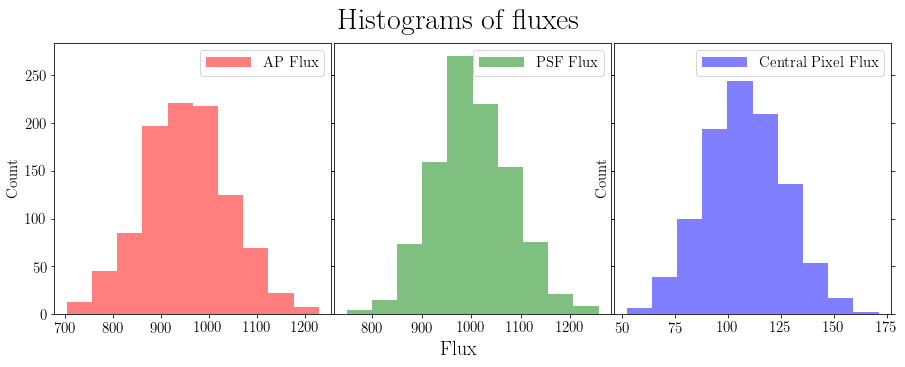

In [9]:
Photometry(1000, corrected= False)

Values are corrected!!

Order of values: Aperture, PSF, Central
Means are:  1000.0 1000.0 1000.0
Standard Deviations are: 93.599, 78.712, 178.072


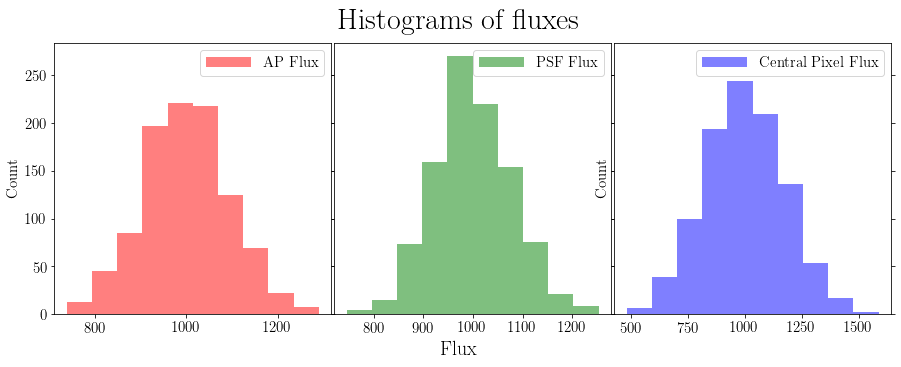

In [10]:
Photometry(1000, corrected=True)

**Comment:** The histogram for the psf flux is the narrowest(as it has the lowest Standard Deviation). The reason being it is the best method to measure the photometric flux. The central pixel method has the highest standard deviation implying it is not a good estimator.